# Baruch ML exam group 09, Annie Yi and Daniel Tuzes

## Fetch and preview the data

In [187]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing(as_frame=True)
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [186]:
california_housing.data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [188]:
california_housing.target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

Text(0.5, 1.0, 'Distribution of house values')

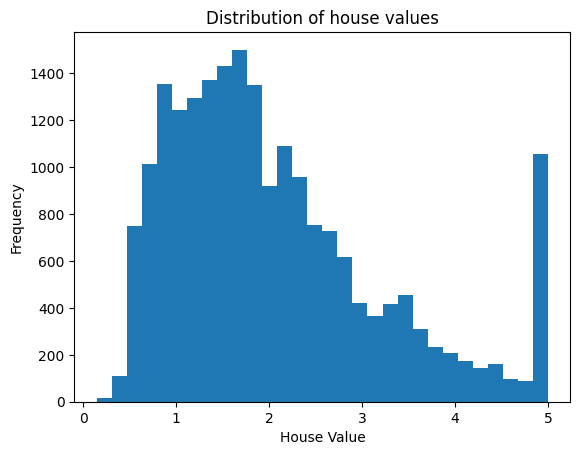

In [189]:
plt.hist(california_housing.target, bins=30)
plt.xlabel('House Value')
plt.ylabel('Frequency')
plt.title('Distribution of house values')

We observed that the distribution has a cut off at 5(MM?), and house values above 5MM may be squeezed to the value 5MM. We don't the details of the data collection, and leave it as it is, believing it is not DQ issue.

Show the correlation between the features and the house prices as target variable

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


<Axes: >

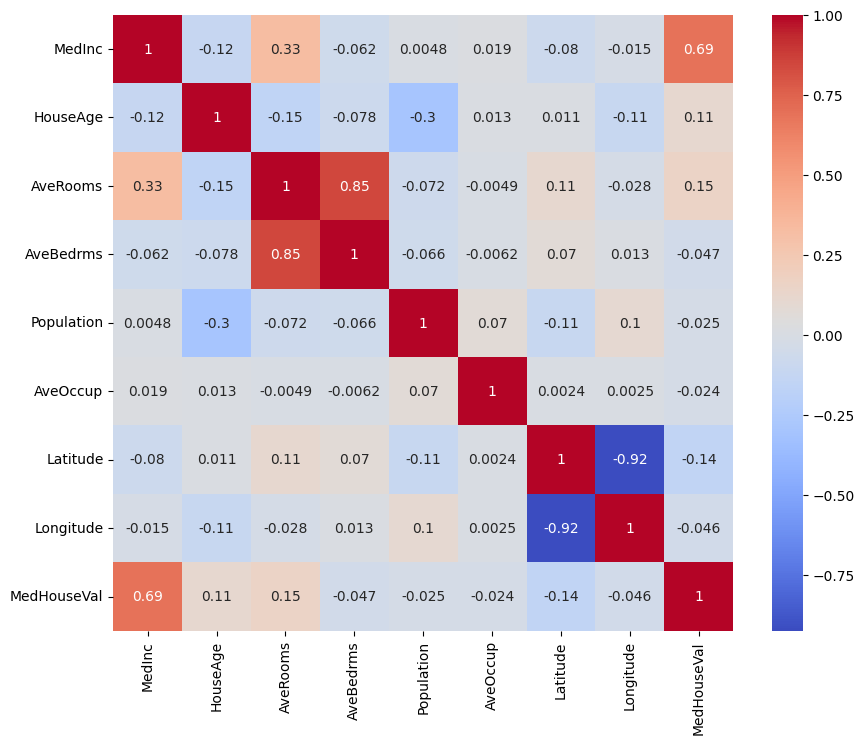

In [190]:
# show correlation between the columns of california_housing.data
corr_matrix = california_housing.data.join(california_housing.target).corr()
display(corr_matrix)
# color the correlation matrix, define plt
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


The map shows that MedHouseVal is positively correlated with MedInc, HouseAge, and AveRooms, and negative with others.

- It is interesting that AveBedrooms is negatively correlated with MedHouseVal, which means that the more bedrooms, the less the house price. But the anti-correlation is not strong.
- The negative correlation betwwen population and house price means that that some of the most expensive houses are in less populated ares. To have a more detailed view on the pair distributions, below a plot of the pariwise correlations.
- Geography does play a role in the house prices, but we expact that it should be correlated with regional blocks, and not latitude and longitude.
- The more people live in 1 household, the lower the price is, because rich families with 1 kid or no kids can afford a more expensive house. Families with more kids can spend less on housing. The effect that more poeple must live in more bedrooms is not strong enough to compensate for the effect of the number of bedrooms on the price.
- There is a strong correlation between the average number of rooms and average number of bedrooms, so will take only one of the for the model. AveRooms is more correlated with the target variable (in absolute values), so we will use that one.

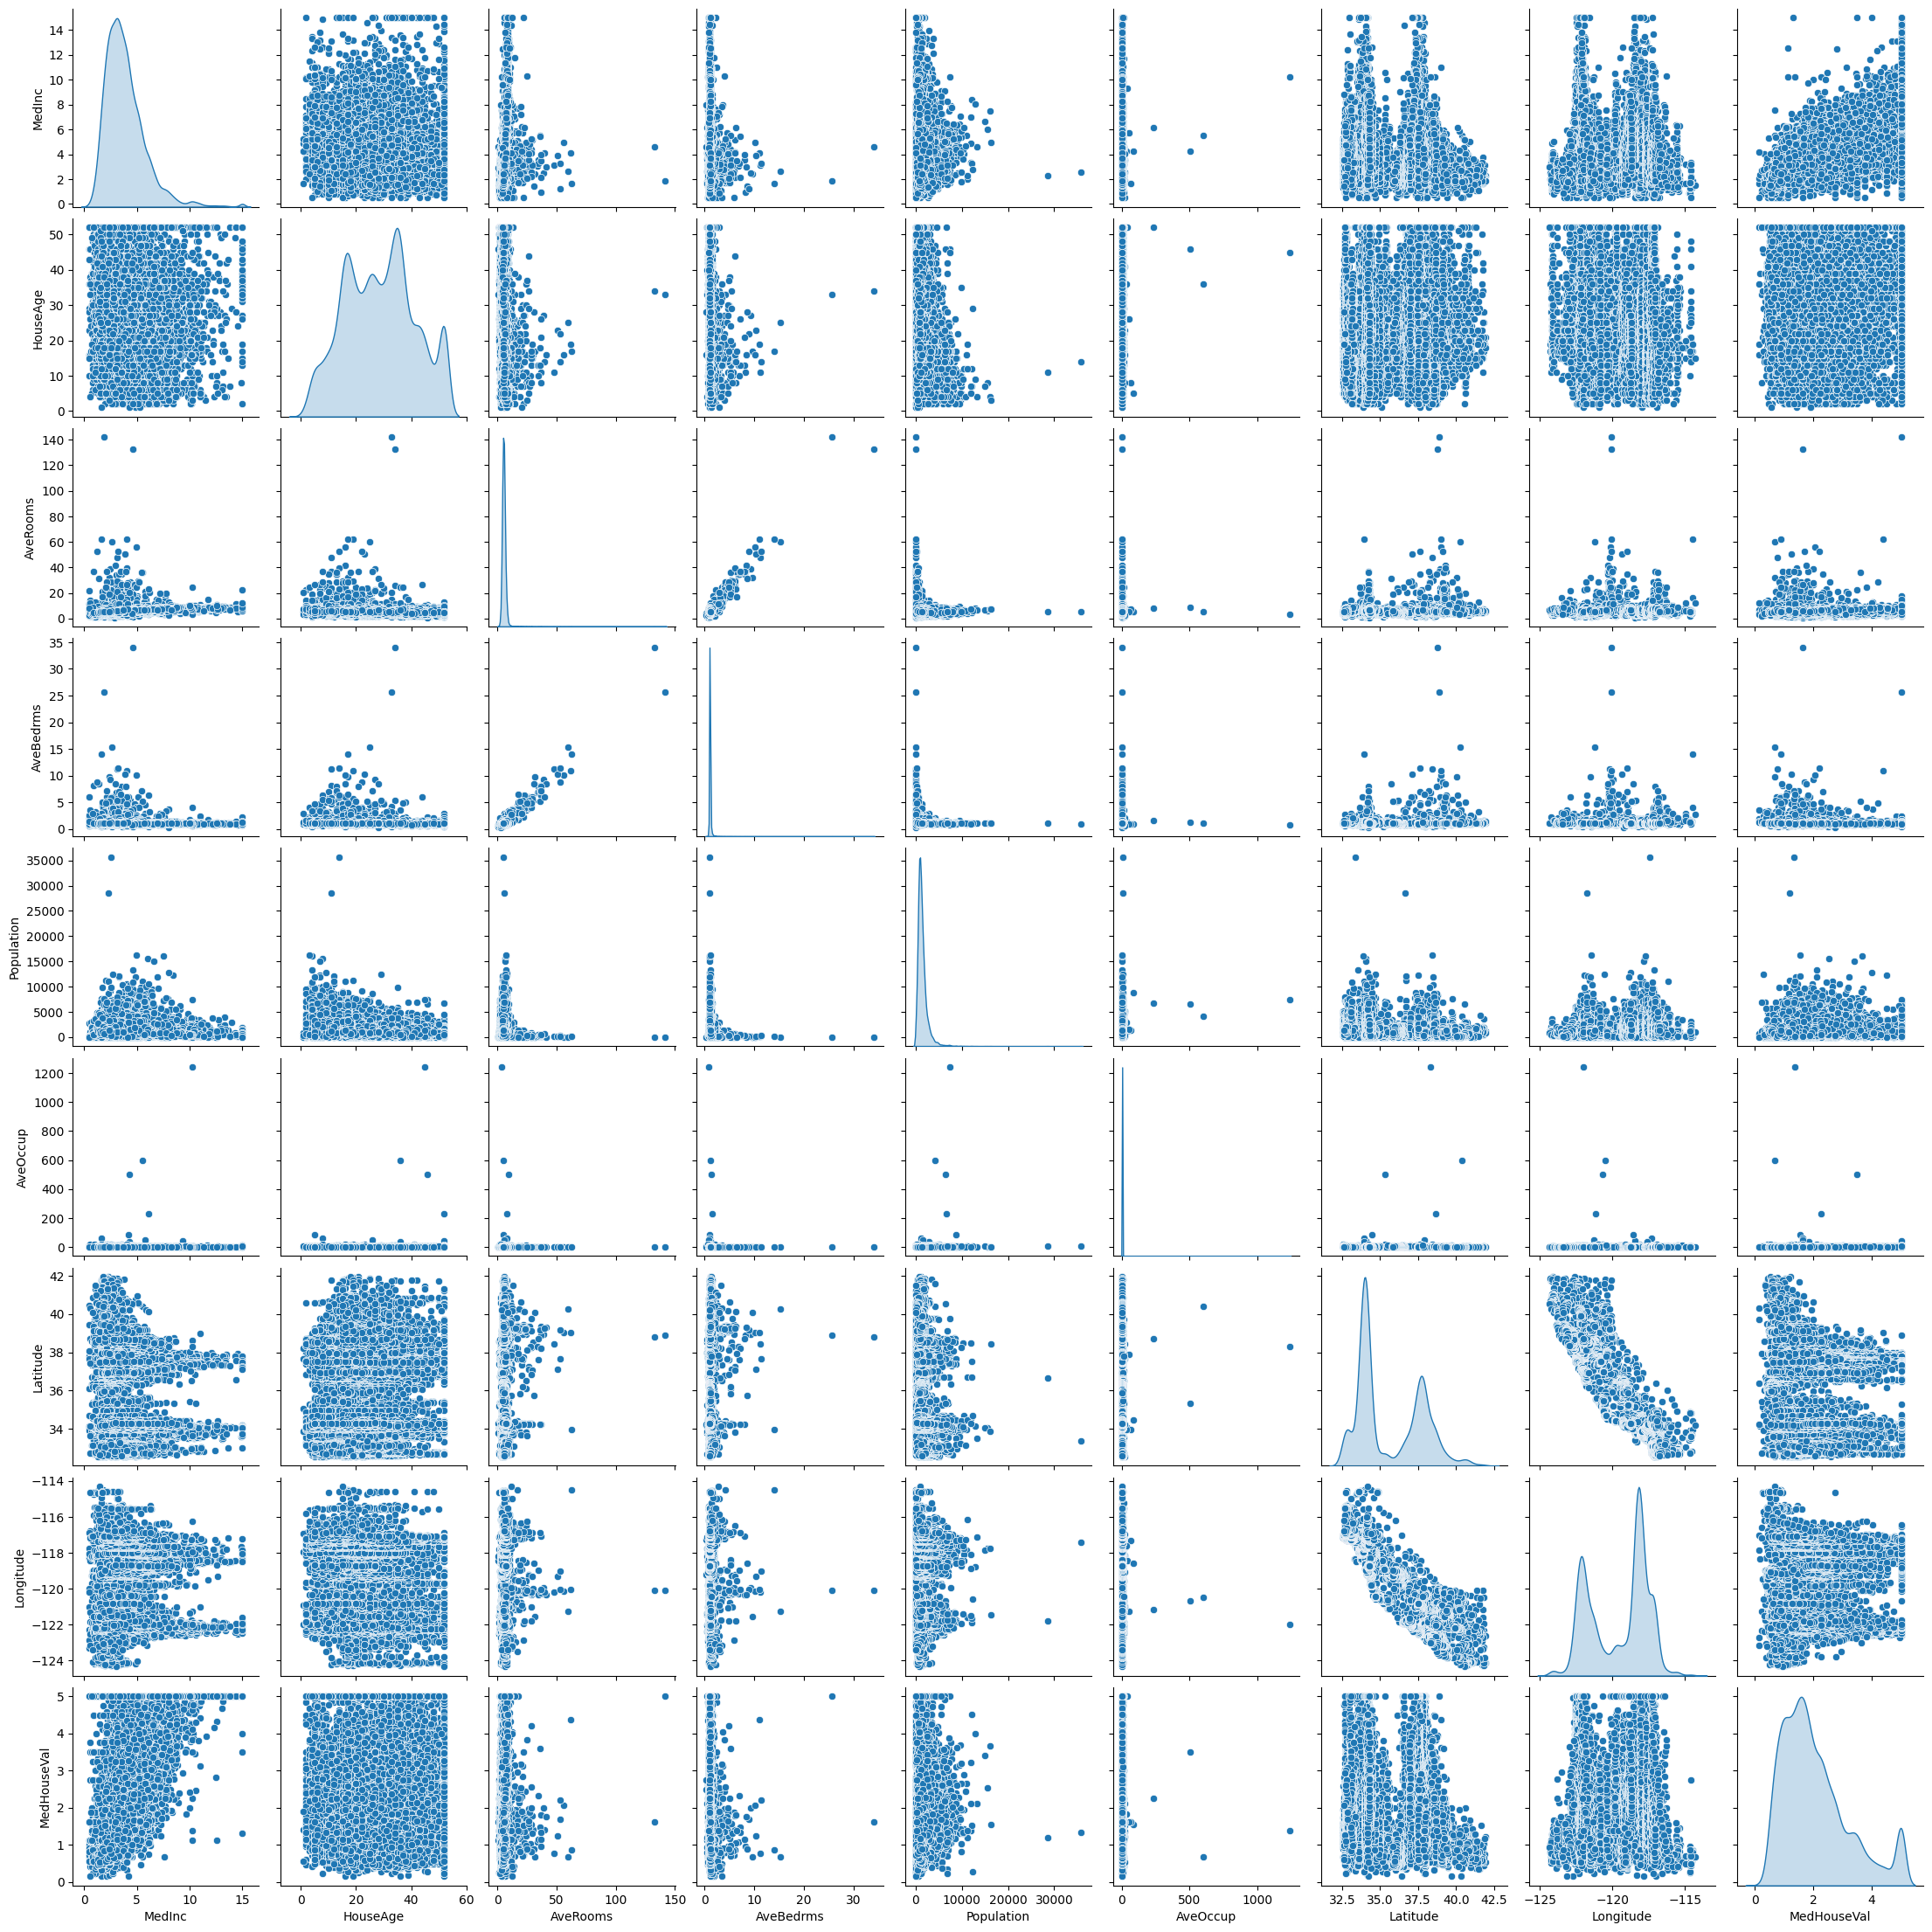

In [143]:
sns.pairplot(california_housing.data.join(california_housing.target), diag_kind='kde')

## Feature selection
Based on the previous observations, and to be able to explain the model, we will use the following features: MedInc, HouseAge, AveRooms, AveOccup and Population.

## Filter and split the data
We restrict our data to the features we selected, and split the data into training and test sets with a 80/20 split. We also randomize the data in case the data is ordered in any way.

In [191]:

X = california_housing.data[['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', "Population"]].values
# Append a column of ones to the data matrix to account for the bias term
X = np.c_[np.ones(X.shape[0]), X]
y = california_housing.target.values

# split the data into trainind and test set
split_ratio = 0.8
num_samples = X.shape[0]
np.random.seed(42)
indices = np.random.permutation(num_samples)  # just reshuffle the indices, now we can split the data in order
split_index = int(num_samples * split_ratio)
train_indices = indices[:split_index]
test_indices = indices[split_index:]
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

In [192]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape  # check the shapes

((16512, 6), (4128, 6), (16512,), (4128,))

## Train the model

Now we can solve the OLS problem as shown in the pdf using numpy (we have done it in HW3 too):
$$\beta ={{\left( {{X}^{T}}X \right)}^{-1}}X^Ty$$
For OLS, we don't need to scale the data, but for feature selection with ridge and lasso, we will need it.

In [193]:
B = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
B

array([ 1.29140466e-02,  4.49838933e-01,  1.74271161e-02, -3.78352270e-02,
       -5.14636020e-03,  2.46815590e-05])

Now let's see how well we perform on the train set.

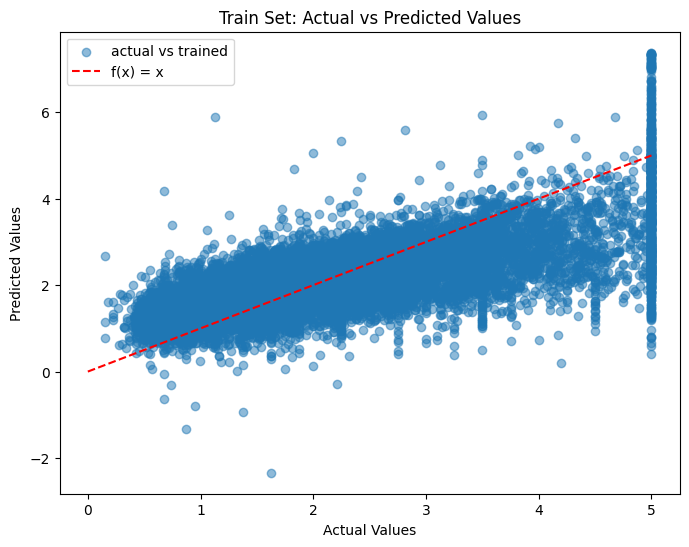

In [196]:
# predict the target values for the train set
y_train_pred = X_train @ B
# plot the predicted values against the actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.xlabel('Actual Values')
# plot the f(x) = x line
plt.plot([0, 5], [0, 5], 'r--')
plt.legend(['actual vs trained', 'f(x) = x'])
plt.ylabel('Predicted Values')
plt.title('Train Set: Actual vs Predicted Values')
plt.show()

Now let's see how well we perform on the test set.

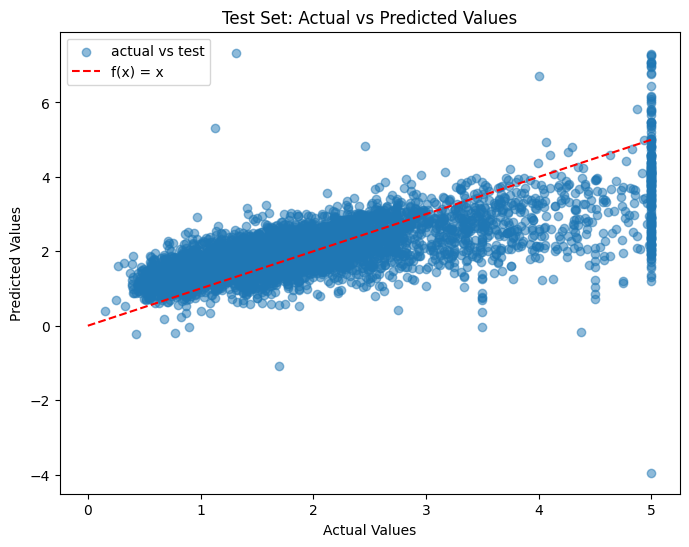

In [197]:
# predict the target values for the test set
y_test_pred = X_test @ B
# plot the predicted values against the actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual Values')
# plot the f(x) = x line
plt.plot([0, 5], [0, 5], 'r--')
plt.legend(['actual vs test', 'f(x) = x'])
plt.ylabel('Predicted Values')
plt.title('Test Set: Actual vs Predicted Values')
plt.show()

We can see that the on the test set, the results are not much worse than on the train set, which is a sign of no high variance. To quanitfy it, we calculate the R2 score, the  residual sum of squares. It measures how much of the variance in the target variable can we explain by the model. The closer to 1, the better. It is a simple metric and the value is independent of the scale of the data.

In [198]:
ss_res_train = np.sum((y_train - y_train_pred)**2)
ss_tot_train = np.sum((y_train - np.mean(y_train_pred))**2)
r_squared_train = 1 - (ss_res_train / ss_tot_train)
print("r_squared_train: ", r_squared_train)

ss_res_test = np.sum((y_test - y_test_pred)**2)
ss_tot_test = np.sum((y_test - np.mean(y_test_pred))**2)
r_squared_test = 1 - (ss_res_test / ss_tot_test)
print("r_squared_test: ", r_squared_test)

r_squared_train:  0.5198577431297431
r_squared_test:  0.4899035675470702


We can also calculate the RMSE, which is the root mean square error. This will tell how much the model is off on average. The lower the RMSE, the better. It is easier to tell the relevance of this metric to the data, because it is in the same scale as the house values. RMSE = $ \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2} $

In [199]:
RMSE = np.sqrt(np.mean((y_test - y_test_pred)**2))
RMSE

0.8286180995589149

In [200]:
np.mean(y_test)

2.0718556104651165

The house prices are in the range of 0.4 to 5, and the RMSE is 0.83 (\$MM). While it is not accurate, definitely better than random guessing. But a realtor should use a more sophisticated model. Zillow and other has historical data, and block level data, which should contribute a lot to the model.

The next step will be to implement ridge regression, to eliminate irrelevant features and to avoid overfitting. We will add back the features we dropped out, and also, filter out house prices which are at 5MM to see if it can improve the model.

## Filter out the 5MM house prices and redo the train/test split

We tried to improve the model by filtering out the 5MM house prices, but it did not help. The r_squared is lower than before, so we will not try to clean the data.

In [211]:
# how much do we filter out? count true values
print("total: ", len(california_housing.target.values))
print("remaining: ", np.sum(california_housing.target.values < 5))

total:  20640
remaining:  19648


In [213]:
X = california_housing.data[['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', "Population"]].values
# Append a column of ones to the data matrix to account for the bias term
X = np.c_[np.ones(X.shape[0]), X]
y = california_housing.target.values

# filter out house prices greater than 5
X = X[y <= 5]
y = y[y <= 5]

# split the data into trainind and test set
split_ratio = 0.8
num_samples = X.shape[0]
np.random.seed(42)
indices = np.random.permutation(num_samples)  # just reshuffle the indices, now we can split the data in order
split_index = int(num_samples * split_ratio)
train_indices = indices[:split_index]
test_indices = indices[split_index:]
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]
X_train.shape, X_test.shape, y_train.shape, y_test.shape  # check the shapes
B = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
B

array([-5.65387574e-04,  4.40077301e-01,  1.59448435e-02, -3.31909023e-02,
       -3.93620856e-03,  3.21713052e-05])

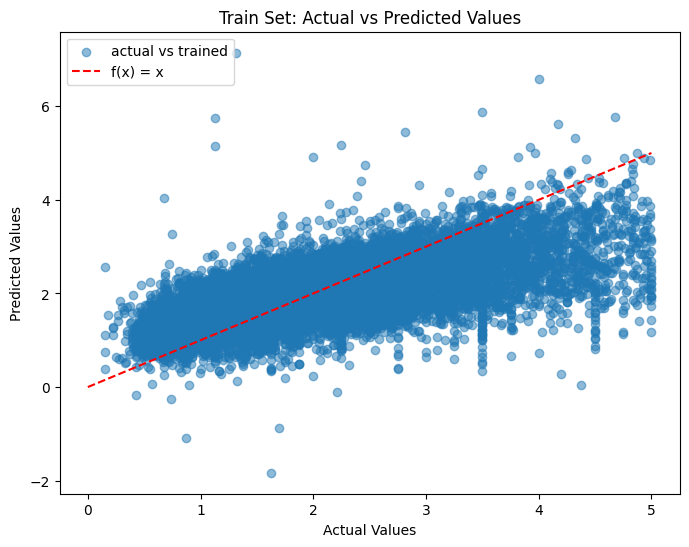

In [214]:
# predict the target values for the train set
y_train_pred = X_train @ B
# plot the predicted values against the actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.xlabel('Actual Values')
# plot the f(x) = x line
plt.plot([0, 5], [0, 5], 'r--')
plt.legend(['actual vs trained', 'f(x) = x'])
plt.ylabel('Predicted Values')
plt.title('Train Set: Actual vs Predicted Values')
plt.show()

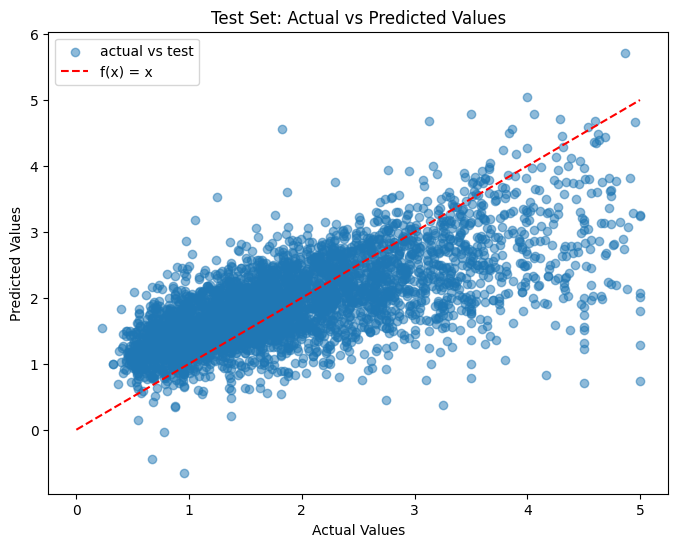

In [217]:
# predict the target values for the test set
y_test_pred = X_test @ B
# plot the predicted values against the actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual Values')
# plot the f(x) = x line
plt.plot([0, 5], [0, 5], 'r--')
plt.legend(['actual vs test', 'f(x) = x'])
plt.ylabel('Predicted Values')
plt.title('Test Set: Actual vs Predicted Values')
plt.show()

In [218]:
ss_res_train = np.sum((y_train - y_train_pred)**2)
ss_tot_train = np.sum((y_train - np.mean(y_train_pred))**2)
r_squared_train = 1 - (ss_res_train / ss_tot_train)
print("r_squared_train: ", r_squared_train)

ss_res_test = np.sum((y_test - y_test_pred)**2)
ss_tot_test = np.sum((y_test - np.mean(y_test_pred))**2)
r_squared_test = 1 - (ss_res_test / ss_tot_test)
print("r_squared_test: ", r_squared_test)

r_squared_train:  0.4591259591005813
r_squared_test:  0.47115204362403773


## Ridge regression

### Add back all the features and redo the train/test split

Below we add back all the features we dropped before so that we can use ridge regression to eliminate the irrelevant features. With the features we tought are less relevant, and the usage of which would be hard to explain actually slightly improved the model. We can see that the R2 score is slightly higher than before and similar for the train and test set. This case, we need to scale the features, because the penalty term depends on scale of the features.

In [240]:
X = california_housing.data.values
# scale the data to have mean 0 and standard deviation 1. To get back later the original values, we need to save the mean and std
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean) / X_std
# Append a column of ones to the data matrix to account for the bias term
X = np.c_[np.ones(X.shape[0]), X]
y = california_housing.target.values

# split the data into trainind and test set
split_ratio = 0.8
num_samples = X.shape[0]
np.random.seed(42)
indices = np.random.permutation(num_samples)  # just reshuffle the indices, now we can split the data in order
split_index = int(num_samples * split_ratio)
train_indices = indices[:split_index]
test_indices = indices[split_index:]
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

In [241]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape  # check the shapes

((16512, 9), (4128, 9), (16512,), (4128,))

In [242]:
B = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
B

array([ 2.06700856,  0.84498499,  0.118311  , -0.29811491,  0.31340891,
       -0.00863296, -0.04298875, -0.88590272, -0.85719466])

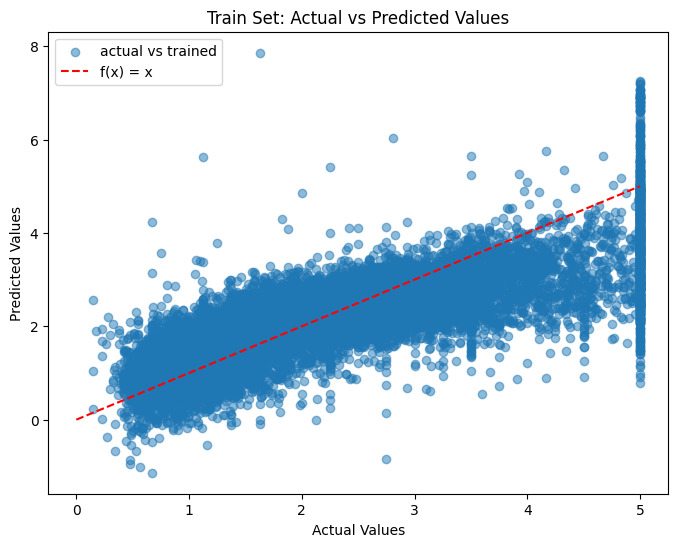

In [243]:
# predict the target values for the train set
y_train_pred = X_train @ B
# plot the predicted values against the actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.xlabel('Actual Values')
# plot the f(x) = x line
plt.plot([0, 5], [0, 5], 'r--')
plt.legend(['actual vs trained', 'f(x) = x'])
plt.ylabel('Predicted Values')
plt.title('Train Set: Actual vs Predicted Values')
plt.show()

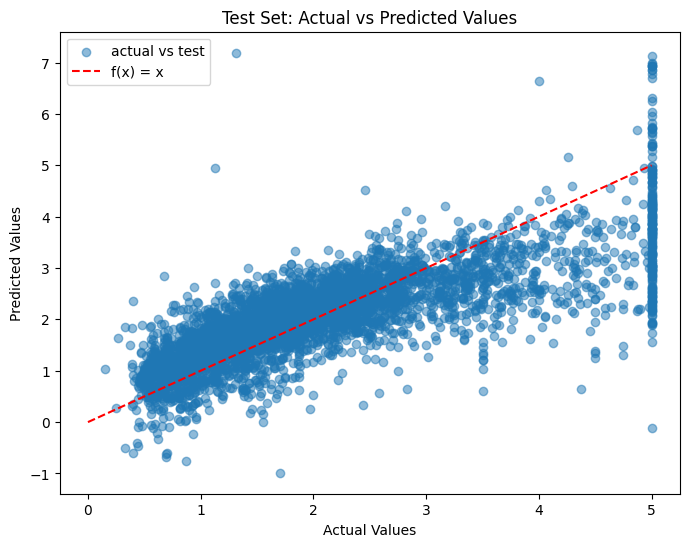

In [244]:
# predict the target values for the test set
y_test_pred = X_test @ B
# plot the predicted values against the actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual Values')
# plot the f(x) = x line
plt.plot([0, 5], [0, 5], 'r--')
plt.legend(['actual vs test', 'f(x) = x'])
plt.ylabel('Predicted Values')
plt.title('Test Set: Actual vs Predicted Values')
plt.show()

In [245]:
ss_res_train = np.sum((y_train - y_train_pred)**2)
ss_tot_train = np.sum((y_train - np.mean(y_train_pred))**2)
r_squared_train = 1 - (ss_res_train / ss_tot_train)
r_squared_train

0.6104651194408386

In [246]:
ss_res_test = np.sum((y_test - y_test_pred)**2)
ss_tot_test = np.sum((y_test - np.mean(y_test_pred))**2)
r_squared_test = 1 - (ss_res_test / ss_tot_test)
r_squared_test

0.5875475978710236

### Define the penalty term and fit the model

Tuning the penalty term is a profession, and we will use different lambda values to test which one is the best. With the penalty term, we do the fitting as
$$\beta ={{\left( {{X}^{T}}X+\lambda I \right)}^{-1}}{{X}^{T}}y$$

In [250]:
B = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
print(B)
lambda_ = 1000
B_ridge = np.linalg.inv(X_train.T @ X_train + lambda_ * np.eye(X_train.shape[1])) @ X_train.T @ y_train
print(B_ridge)

[ 2.06700856  0.84498499  0.118311   -0.29811491  0.31340891 -0.00863296
 -0.04298875 -0.88590272 -0.85719466]
[ 1.94912809  0.77869272  0.15288633 -0.14840835  0.14808162  0.00415848
 -0.04297351 -0.50410725 -0.46733346]


In [252]:
# add the penalty term to the cost function
lambdas = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
r_squared_train_list = []
r_squared_test_list = []
weights_list = []
for lambda_ in lambdas:
    B_ridge = np.linalg.inv(X_train.T @ X_train + lambda_ * np.eye(X_train.shape[1])) @ X_train.T @ y_train
    weights_list.append(B_ridge)
    y_train_pred = X_train @ B_ridge
    ss_res_train = np.sum((y_train - y_train_pred)**2)
    ss_tot_train = np.sum((y_train - np.mean(y_train_pred))**2)
    r_squared_train = 1 - (ss_res_train / ss_tot_train)
    r_squared_train_list.append(r_squared_train)

    y_test_pred = X_test @ B_ridge
    ss_res_test = np.sum((y_test - y_test_pred)**2)
    ss_tot_test = np.sum((y_test - np.mean(y_test_pred))**2)
    r_squared_test = 1 - (ss_res_test / ss_tot_test)
    r_squared_test_list.append(r_squared_test)

res = pd.DataFrame({'lambda': lambdas, 'r_squared_train': r_squared_train_list, 'r_squared_test': r_squared_test_list})
weights_df = pd.DataFrame(weights_list, columns=[f'weight_{i}' for i in range(len(weights_list[0]))])
# reaname the columns of weights_df to match with the data column names MedInc, HouseAge, AveRooms, AveOccup, Population 
weights_df.columns = ['bias'] + california_housing.data.columns.tolist()

res = pd.concat([res, weights_df], axis=1)
res

,lambda,r_squared_train,r_squared_test,bias,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1,0.610465,0.587548,2.066884,0.844939,0.118391,-0.297928,0.313176,-0.008604,-0.042994,-0.885151,-0.856433
1,2,0.610465,0.587547,2.066759,0.844893,0.118471,-0.297741,0.312944,-0.008575,-0.042998,-0.884400,-0.855673
2,5,0.610463,0.587546,2.066384,0.844752,0.118709,-0.297180,0.312246,-0.008488,-0.043012,-0.882158,-0.853402
3,10,0.610458,0.587541,2.065760,0.844515,0.119103,-0.296243,0.311085,-0.008345,-0.043036,-0.878452,-0.849648
4,20,0.610436,0.587521,2.064514,0.844028,0.119878,-0.294365,0.308769,-0.008063,-0.043080,-0.871149,-0.842249
5,50,0.610292,0.587392,2.060783,0.842472,0.122104,-0.288700,0.301874,-0.007252,-0.043202,-0.850090,-0.820897
6,100,0.609820,0.586969,2.054593,0.839621,0.125509,-0.279238,0.290601,-0.006008,-0.043368,-0.817561,-0.787874
7,200,0.608198,0.585512,2.042322,0.833266,0.131346,-0.260632,0.269089,-0.003870,-0.043589,-0.760583,-0.729908
8,500,0.600219,0.578286,2.006358,0.812332,0.143323,-0.210635,0.213857,0.000551,-0.043686,-0.634082,-0.600704
9,1000,0.583034,0.562525,1.949128,0.778693,0.152886,-0.148408,0.148082,0.004158,-0.042974,-0.504107,-0.467333


We introduced a bug we found only later: after scaling, lambda needs to be on a different scale. So we can see the changing values again (compare with the previous juypter we submitted.)

Previously we saw that the weights are decreasing, but they don't disappear, as we would expect for some in lasso regression. It is interesting that the weight for AveRooms turned to negative, which must be considered together with the other features like AveBedrooms. It seems that there was a better correlation with bedrooms, and the average number of rooms, given the number or bedrooms, rather anti-correlated with the house prices.

The model performs similarly for both train and test sets, and the r_squared does not increase for the test set with the penalty term at all, meaning that the model is not overfitting. With the bias, we have 9 features, and the dataset has more than 20'000 samples, and there is no correlation in the input sequence (like time), therefore we don't expect overfitting.

## PCA

Let's see how much of the variance we can keep by removing some of the features.

In [165]:
# the data needs to be scaled and centered
X = california_housing.data.values
X_scaled_centered = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# compute the covariance matrix
cov_matrix = np.cov(X_scaled_centered.T)
# compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
# sort the eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]



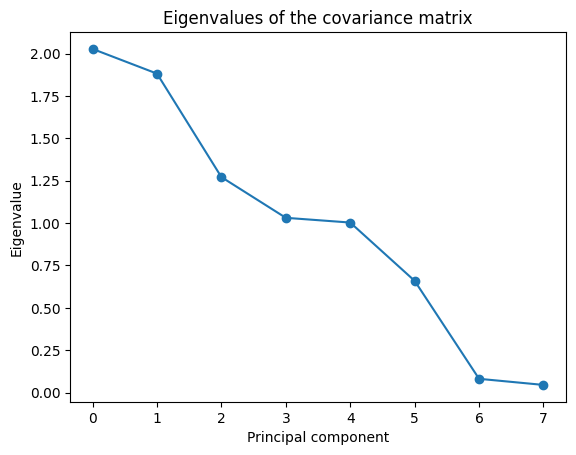

In [166]:
# plot the eigenvalues
plt.plot(eigenvalues, marker='o')
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the covariance matrix')
plt.show()

We can see that the last 2 dimension brings little contribution to the variance (not that the y axis starts from 0). We either stop at the 3rd principal value, or keep till the 6th, because the 4th and 5th are not much lower than the previous 3. There is a sudden drop from 2 to 3, and then from 5th till 7th. We can train the model for all principal components though and see whether it performs as expected. To get back the original features, we would need to scale back the data.

In [167]:
# set of new features
n_eigenvectors = 2
X_pca = X_scaled_centered @ eigenvectors[:, :n_eigenvectors]